# Modeling - Option 1:
## Predicting affluence in our NYC clusters

__Context and Motivation for this modeling exercise__:
In the prior Data Cleaning & Exploratory Data Analysis notebook, we noted some very interesting insights based on the relative percentages of business types in each NYC Borough.

Here are some example observations we made, related to business categories within the borough: 
- Manhattan has a higher percentage of coffee shops relative to other business types
- Bronx and Staten Island have a higher percentage of Pizza shops
- Queens larger percentage of Chinese businesses, relative to other types
- Staten Island has the highest percentage of Hot Dog businesses

Also, we had made some observations based on the business 'price' level (example: \$\$)
- Manhattan has a predominance of 2 dollar sign businesses 
- Manhattan also the largest percentage of 3 and 4 dollar-sign businesses relative to the other boroughs
- Bronx contains predominantly 1 dollar sign businesses.

We believe that these observations are key in highlighting the relative types of businesses within a neighborhood and could be a predictor of affluence. In this notebook, we explore these types of questions via modeling methods - to establish whether we can predict the affluence of one of our business 'clusters' by utilizing the percentages of types of businesses within all clusters.


## Import Libraries and Data

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn import svm

from sklearn.metrics import confusion_matrix, roc_curve, auc, make_scorer, roc_auc_score

import matplotlib

# Styling 
from IPython.display import HTML, display
import tabulate

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline


### Load data

In [2]:
# Import our clean yelp data, with the cluster and 'is_affluent' columns

yelp = pd.read_csv('../data/yelp_clean.csv')

## Feature Engineering: creating fractional columns

In [3]:
# Quick view of the data set
yelp.head()

,Unnamed: 0,name,review_count,rating,price,cat1,zip_code,nyc,borough,cluster,is_affluent
0,0,Com Tam Ninh Kieu,379,4.0,2,vietnamese,10468,True,Bronx,12,0
1,1,Antonio's Trattoria,773,4.5,2,italian,10458,True,Bronx,12,0
2,2,Bronx Alehouse,749,4.0,2,tradamerican,10463,True,Bronx,62,0
3,4,The Bronx Public,443,4.0,2,sportsbars,10463,True,Bronx,62,0
4,5,Trattoria Zero Otto Nove,749,4.0,2,italian,10458,True,Bronx,12,0


In [4]:
# We define a function to calculate the percentage presence for each feature category across all the others
# In our current use case, the group is our cluster and the fraction is the % of the feature type (price or category)
def class_fraction_feature(df_feature, group_col, feature_col):
    '''Function to create percent features. Take in a data frame, df_feature, collect the 
    categories in the group_col identify the features in feature_col and give a percent of the feature for the group.
    '''
    # identify unique groups and the unique features
    groups   = df_feature[group_col].unique().tolist()
    features = df_feature[feature_col].unique().tolist()    
    
    # Create a dictionary to store the groups. Iterate through the groups and collect counts for the features
    data = []
    for g in groups:
        # empty dictionary, which will be filled with groups
        g_dict = {'group_col':g}
        
        for f in features:
            g_dict[f] = df_feature[(df_feature[group_col]==g)&(df_feature[feature_col]==f)][feature_col].count()
    
        # append the dictionary entry for a group to the list of groups
        data.append(g_dict)
        
    data = pd.DataFrame(data)
    
    # Create total by row and create fraction on each column
    data['total'] = data[features].sum(axis = 1)
    for f in features:
        data[ str(f) + '_fraction'] = data[f]/data['total']
   
    return data

In [5]:
# We calculate the percentages for each business type:  by category type & price
cluster_price_fraction = class_fraction_feature(yelp,'cluster','price')
cluster_type_fraction = class_fraction_feature(yelp,'cluster','cat1')


In [6]:
# As an example, we show the fraction table for 'price'.
cluster_price_fraction.head()

,group_col,2,1,3,4,total,2_fraction,1_fraction,3_fraction,4_fraction
0,12,76,129,3,1,209,0.363636,0.617225,0.014354,0.004785
1,62,72,69,3,0,144,0.500000,0.479167,0.020833,0.000000
2,42,70,74,1,0,145,0.482759,0.510345,0.006897,0.000000
3,38,21,70,0,0,91,0.230769,0.769231,0.000000,0.000000
4,56,42,108,0,1,151,0.278146,0.715232,0.000000,0.006623


In [7]:
# Create a reference dataframe of the cluster numbers and their affluence category
cluster_is_affluent = yelp[['cluster', 'is_affluent']]
cluster_is_affluent = cluster_is_affluent.drop_duplicates(keep ='first')

In [8]:
# Join the fractions together to create a combined set for the clusters
cluster_fraction = cluster_price_fraction.merge(cluster_type_fraction, on = 'group_col', suffixes = ('_x','_y'))

# join on affluence
cluster_fraction = cluster_fraction.rename(columns={'group_col':'cluster'})
cluster_fraction = cluster_is_affluent.merge(cluster_fraction, on = 'cluster')

In [9]:
# We view the dataframe with all count and fractional columns. (We will remove some of these soon)
cluster_fraction.head()

,cluster,is_affluent,2,1,3,4,total_x,2_fraction,1_fraction,3_fraction,...,giftshops_fraction,spas_fraction,singaporean_fraction,diyfood_fraction,kids_activities_fraction,shopping_fraction,cookingschools_fraction,burmese_fraction,sicilian_fraction,farmersmarket_fraction
0,12,0,76,129,3,1,209,0.363636,0.617225,0.014354,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,62,0,72,69,3,0,144,0.500000,0.479167,0.020833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,42,0,70,74,1,0,145,0.482759,0.510345,0.006897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,38,0,21,70,0,0,91,0.230769,0.769231,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,56,0,42,108,0,1,151,0.278146,0.715232,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In the table above, we see a full dataframe with all the newly engineered fraction columns. We will add two more, based on grouping together the 1 & 2 dollar sign businesses, and 3 & 4 dollar sign businesses. Per the Exploratory Data Analysis we performed previously, this may help as an indicator of affluence.

In [10]:
# Adding two engineered columns based on dollar sign groupings
cluster_fraction['1_2_fraction'] = cluster_fraction['1_fraction'] + cluster_fraction['2_fraction']
cluster_fraction['3_4_fraction'] = cluster_fraction['3_fraction'] + cluster_fraction['4_fraction']

Next, we will utilize list comprehension to remove all of the original 'count' columns from our dataframe. 

In [11]:
# Remove columns that are based on count, vs fraction

cols = [c for c in cluster_fraction.columns if str(c).endswith('fraction')] # Keep columns with '_fraction'
cols.append('is_affluent') # ensure that our target 'is_affluent' category is maintained      

In [12]:
cluster_fraction = cluster_fraction[cols] # redefine our dataframe with the selected columns

In [13]:
# This our final goal dataframe - with all the fractional categories & the affluence (target) column
cluster_fraction.head()

,2_fraction,1_fraction,3_fraction,4_fraction,vietnamese_fraction,italian_fraction,tradamerican_fraction,sportsbars_fraction,desserts_fraction,mexican_fraction,...,diyfood_fraction,kids_activities_fraction,shopping_fraction,cookingschools_fraction,burmese_fraction,sicilian_fraction,farmersmarket_fraction,1_2_fraction,3_4_fraction,is_affluent
0,0.363636,0.617225,0.014354,0.004785,0.004785,0.081340,0.019139,0.014354,0.000000,0.071770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.980861,0.019139,0
1,0.500000,0.479167,0.020833,0.000000,0.000000,0.013889,0.034722,0.020833,0.020833,0.048611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.979167,0.020833,0
2,0.482759,0.510345,0.006897,0.000000,0.000000,0.013793,0.013793,0.013793,0.020690,0.089655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.993103,0.006897,0
3,0.230769,0.769231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0
4,0.278146,0.715232,0.000000,0.006623,0.000000,0.013245,0.013245,0.006623,0.000000,0.052980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.993377,0.006623,0


Above is our final dataframe that we will carry forward to modeling. We will be exploring the relationship between the relative presence of business types as they relate to prediction affluence.

# Model Preparation

In [14]:
target = 'is_affluent'
X = cluster_fraction.drop(columns=target)
y = cluster_fraction[target]

# Train, Test Split


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, stratify=y)

### Check distributions of Y to see if we have balanced classes

In [16]:
# Check distribution of y, to see if y has unbalanced classes
y.value_counts(normalize=True)

0    0.531646
1    0.468354
Name: is_affluent, dtype: float64

In [17]:
# Check distribution of y_train
y_train.value_counts(normalize=True)

0    0.525424
1    0.474576
Name: is_affluent, dtype: float64

In [18]:
# Check distribution of y_test
y_test.value_counts(normalize=True)

0    0.55
1    0.45
Name: is_affluent, dtype: float64

# Modeling: First Round

- In the modeling process, we will first present our baseline model.  
- We will then develop several models, evaluating via GridSearch. 
- Based on the Grid Search's cross validation scores, we will then fine tune the hyper-parameters for each model to achieve the optimal result. 

## Evaluation Metric: ROC

A few notes about our chosen evaluation metric, ROC: 

- "ROC (Receiver Operating Characteristic) is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes"[(reference)](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5). The higher the ROC, and the better it the two classes: Affluent vs. Not Affluent. The ROC curve is plotted with True Positive Rate on y-axis, against the False Positive Rate on the x-axis.

- AUC (Area Under the Curve) measures the entire two-dimensional area underneath the entire ROC curve. The closer AUC to 1, the better the model.

- We are choosing the AUC ROC  as our metric, since our aim is to find the optimal model that best separates our Affluence classes.

##  Baseline Model

In [19]:
y_test.value_counts(normalize=True)[0]

0.55

Our baseline score is 55%, indicating that we were to blindly predict that each cluster were "not affluent", we would be correct 55% of the time.

## Logistic Regression

### Additional modeling

In [33]:
pipe = Pipeline(steps=[ 
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(solver='liblinear'))
])

pipe_params ={
    'lr__C': [0.0001, .001, .01],
    'lr__penalty' : ['l1', 'l2']
    }

gs_lr = GridSearchCV(pipe, 
                     pipe_params, 
                     cv=3,
                     scoring='roc_auc')


In [34]:
gs_lr.fit(X_train, y_train);

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [35]:
# Check the optimal params
gs_lr.best_params_

{'lr__C': 0.0001, 'lr__penalty': 'l2'}

In [36]:
gs_lr.best_estimator_

Pipeline(memory=None,
         steps=[('ss',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr',
                 LogisticRegression(C=0.0001, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [37]:
# Train score
gs_lr.score(X_train, y_train)

0.9723502304147466

In [38]:
# Test score
gs_lr.score(X_test, y_test)

0.8686868686868686

In [39]:
# Cross val score on the whole dataset 
cv_lr = cross_val_score(gs_lr.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()
cv_lr

0.7956349206349206

In [40]:
coef_lr_gs = np.array((gs_lr.best_estimator_.named_steps['lr']).coef_).tolist()[0]


In [41]:
names = X_train.columns

In [42]:
gs_lr_betas = list(zip(names, coef_lr_gs))
gs_lr_betas

[('2_fraction', 0.0011272620746217545),
 ('1_fraction', -0.001137934900469253),
 ('3_fraction', 0.000588008982300437),
 ('4_fraction', 0.00105745910090655),
 ('vietnamese_fraction', 0.0007109233308867271),
 ('italian_fraction', 0.0003575183330013801),
 ('tradamerican_fraction', -0.00021806327081357814),
 ('sportsbars_fraction', 9.15728871188477e-05),
 ('desserts_fraction', 0.00046073421450833825),
 ('mexican_fraction', -0.00018560632238710453),
 ('coffee_fraction', 0.001289230296031531),
 ('bars_fraction', 0.0005744457720120626),
 ('breakfast_brunch_fraction', 0.0002557160177083298),
 ('comfortfood_fraction', -0.0008842194492456573),
 ('delis_fraction', 3.700596576506998e-06),
 ('pizza_fraction', -0.0013835817491417912),
 ('bakeries_fraction', 8.26338487845695e-05),
 ('japanese_fraction', -0.000136318405759492),
 ('venezuelan_fraction', -0.00022856282920063353),
 ('catering_fraction', 0.0002815646359444142),
 ('greek_fraction', 0.000286393488163758),
 ('burgers_fraction', -0.0002841251

In [43]:
# Create final dataframe of words with their corresponding coefficients
gs_lr_coefs = pd.DataFrame(gs_lr_betas).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = False)

In [44]:
gs_lr_coefs[gs_lr_coefs['coef'] != 0]

,word,coef
80,french_fraction,0.001762
107,ramen_fraction,0.001518
102,cocktailbars_fraction,0.001508
36,cafes_fraction,0.001393
153,beerbar_fraction,0.001382
...,...,...
29,diners_fraction,-0.000938
1,1_fraction,-0.001138
56,donuts_fraction,-0.001181
55,hotdogs_fraction,-0.001245


## KNN model

In [45]:
# Pipe line: CountVectorizer() + LogisticRegression
pipe_knn = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_params_knn ={
    'knn__n_neighbors' : [5, 10, 15, 20]
    
}

gs_knn = GridSearchCV(pipe_knn, 
                      pipe_params_knn, 
                      cv=3,
                      scoring='roc_auc')

In [46]:
gs_knn.fit(X_train, y_train);

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [47]:
# Check the optimal params
gs_knn.best_params_

{'knn__n_neighbors': 15}

In [48]:
# Train score
gs_knn.score(X_train, y_train)

0.9164746543778802

In [49]:
# Test score
gs_knn.score(X_test, y_test)

0.8636363636363636

In [50]:
# Cross val score on the whole dataset 
cv_knn = cross_val_score(gs_knn.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()
cv_knn

0.7218406593406593

## Trees

### Decision Tree

In [51]:
pipe_dt = Pipeline(steps=[
    ('ss', StandardScaler()), 
    ('dt', DecisionTreeClassifier(random_state=42))
])

pipe_params_dt = {
    'dt__max_depth': [3, 5],
    'dt__min_samples_split': [2, 3],
    'dt__min_samples_leaf': [1, 5, 10]}

gs_dt = GridSearchCV(pipe_dt, 
                     pipe_params_dt, 
                     cv=3,
                     scoring='roc_auc')

In [52]:
gs_dt.fit(X_train, y_train);

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [53]:
# Check the optimal params
gs_dt.best_params_

{'dt__max_depth': 3, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 2}

In [54]:
# Train score
gs_dt.score(X_train, y_train)

0.9475806451612903

In [55]:
# Test score
gs_dt.score(X_test, y_test)

0.7929292929292929

In [56]:
# Cross val score on the whole dataset 
cv_dt = cross_val_score(gs_dt.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()
cv_dt

0.7343559218559218

In [57]:
#coef_dt_gs = np.array((gs_dt.best_estimator_.named_steps['dt']).coef_).tolist()[0]

### Bagging Classifier

In [58]:
pipe_bc = Pipeline(steps=[
    ('ss', StandardScaler()), 
    ('bc', BaggingClassifier(random_state=42))
])

pipe_params_bc = {
    'bc__n_estimators': [5, 10, 15],
    'bc__max_samples': [1, 2, 3]}

gs_bc = GridSearchCV(pipe_bc, 
                     pipe_params_bc, 
                     cv=3,
                     scoring='roc_auc')

In [59]:
gs_bc.fit(X_train, y_train);

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [60]:
# Check the optimal params
gs_bc.best_params_

{'bc__max_samples': 3, 'bc__n_estimators': 15}

In [61]:
# Train score
gs_bc.score(X_train, y_train)

0.8513824884792627

In [62]:
# Test score
gs_bc.score(X_test, y_test)

0.8282828282828282

In [63]:
# Cross val score on the whole dataset 
cv_bc = cross_val_score(gs_bc.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()
cv_bc

0.764957264957265

In [64]:
#coef_bc_gs = np.array((gs_bc.best_estimator_.named_steps['bc']).coef_).tolist()[0]

### Random Forest

In [65]:
pipe_rf = Pipeline(steps=[ 
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_params_rf = {
    'rf__max_depth': [3, 5],
    'rf__min_samples_split': [2, 3],
    'rf__min_samples_leaf': [1, 5, 10]}


gs_rf = GridSearchCV(pipe_rf, 
                     pipe_params_rf, 
                     cv=3,
                     scoring='roc_auc')

In [66]:
gs_rf.fit(X_train, y_train);

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [67]:
# Check the optimal params
gs_rf.best_params_

{'rf__max_depth': 5, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 3}

In [68]:
# Train score
gs_rf.score(X_train, y_train)

1.0

In [69]:
# Test score
gs_rf.score(X_test, y_test)

0.8333333333333334

In [70]:
# Cross val score on the whole dataset 
cv_rf = cross_val_score(gs_rf.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()
cv_rf

0.8582112332112333

In [71]:
# Evaluate Training Scores for each Classification Model
print('Training Scores:')
print(f'Logistic Regression:                          {gs_lr.score(X_train_sc, y_train):.3f}')
print(f'K-Nearest Neighbors Classification:           {gs_knn.score(X_train_sc, y_train):.3f}')
print(f'Decision Tree Classification:                 {gs_dt.score(X_train_sc, y_train):.3f}')
print(f'Set of Bagged Decision Trees Classification:  {gs_bc.score(X_train_sc, y_train):.3f}')
print(f'Random Forest Classification:                 {gs_rf.score(X_train_sc, y_train):.3f}')


Training Scores:
Logistic Regression:                          0.988
K-Nearest Neighbors Classification:           0.882
Decision Tree Classification:                 0.906
Set of Bagged Decision Trees Classification:  0.830
Random Forest Classification:                 0.926


In [72]:
# Evaluate Testing Scores for each Classification Model
print('Testing Scores:')
print(f'Logistic Regression:                          {gs_lr.score(X_test_sc, y_test):.3f}')
print(f'K-Nearest Neighbors Classification:           {gs_knn.score(X_test_sc, y_test):.3f}')
print(f'Decision Tree Classification:                 {gs_dt.score(X_test_sc, y_test):.3f}')
print(f'Set of Bagged Decision Trees Classification:  {gs_bc.score(X_test_sc, y_test):.3f}')
print(f'Random Forest Classification:                 {gs_rf.score(X_test_sc, y_test):.3f}')


Testing Scores:
Logistic Regression:                          0.808
K-Nearest Neighbors Classification:           0.768
Decision Tree Classification:                 0.843
Set of Bagged Decision Trees Classification:  0.874
Random Forest Classification:                 0.884


In [73]:
# Evaluate Cross Validation scores for each Classification Model
print('Training Scores:')
print(f'Logistic Regression:                          {cv_lr:.3f}')
print(f'K-Nearest Neighbors Classification:           {cv_knn:.3f}')
print(f'Decision Tree Classification:                 {cv_dt:.3f}')
print(f'Set of Bagged Decision Trees Classification:  {cv_bc:.3f}')
print(f'Random Forest Classification:                 {cv_rf:.3f}')


Training Scores:
Logistic Regression:                          0.796
K-Nearest Neighbors Classification:           0.722
Decision Tree Classification:                 0.734
Set of Bagged Decision Trees Classification:  0.765
Random Forest Classification:                 0.858


# Model Selection

## Model Evaluation

### Confusion Matrix

In [74]:
y_pred = gs_rf.predict(X_test_sc)

In [75]:
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

In [76]:
cm = confusion_matrix(y_test, y_pred)

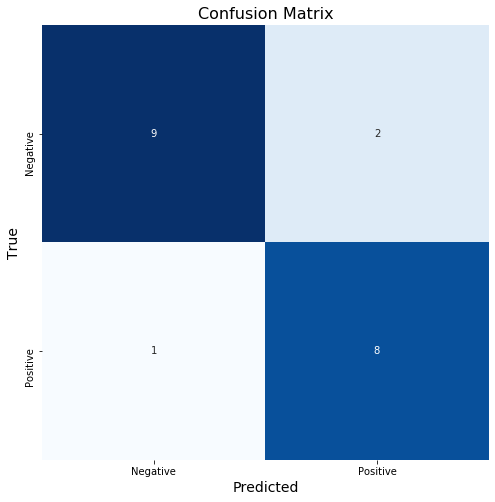

In [77]:
plt.figure(figsize = (8,8))
ax = plt.subplot()
sns.heatmap(cm, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('True', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

### ROC Curve and AUC ROC

In [78]:
y_pred_proba = gs_rf.predict_proba(X_test_sc)

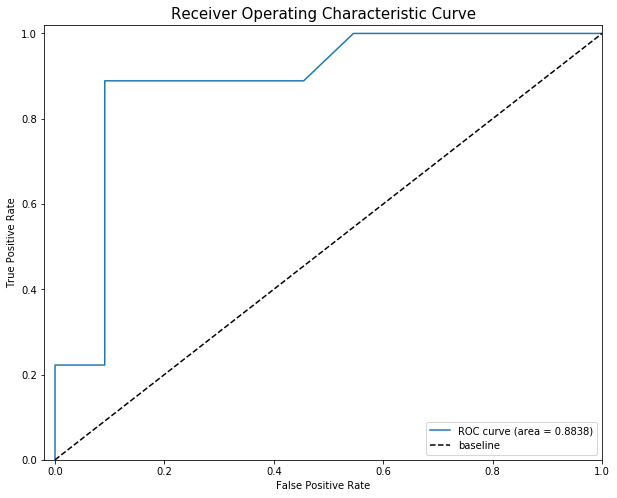

In [79]:
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
fpr, tpr, _= roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)


# Plot of a ROC curve for a specific class
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve', fontsize=15)
plt.legend(loc="lower right");